<a href="https://colab.research.google.com/github/aysenurrakcan/HackBio-StageThree/blob/main/stage_three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet scanpy anndata matplotlib seaborn python-igraph louvain harmonypy


In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, re

from importlib.metadata import version
print("Scanpy version:", version("scanpy"))

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=False)


Scanpy version: 1.11.5


In [3]:
# RAW MTX+TSV arşivini indir
if not os.path.exists("GSE166766_RAW.tar"):
    !wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar" -O GSE166766_RAW.tar
else:
    print("GSE166766_RAW.tar already exists.")

# Çıkartılacak klasör
os.makedirs("GSE166766_RAW", exist_ok=True)

# TAR içeriğini bu klasöre aç
!tar -xvf GSE166766_RAW.tar -C GSE166766_RAW


--2025-11-29 17:38:39--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 838123520 (799M) [application/x-tar]
Saving to: ‘GSE166766_RAW.tar’

GSE166766_RAW.tar   100%[===================>] 799.30M  48.8MB/s    in 19s     

2025-11-29 17:38:58 (42.4 MB/s) - ‘GSE166766_RAW.tar’ saved [838123520/838123520]

GSM5082289_mock_barcodes.tsv.gz
GSM5082289_mock_features.tsv.gz
GSM5082289_mock_matrix.mtx.gz
GSM5082290_1dpi_barcodes.tsv.gz
GSM5082290_1dpi_features.tsv.gz
GSM5082290_1dpi_matrix.mtx.gz
GSM5082291_2dpi_barcodes.tsv.gz
GSM5082291_2dpi_features.tsv.gz
GSM5082291_2dpi_matrix.mtx.gz
GSM5082292_3dpi_barcodes.tsv.gz
GSM5082292_3dpi_features.tsv.gz
GSM5082292_3dpi_matrix.mtx.gz


In [4]:
mtx_dirs = []

for root, dirs, files in os.walk("GSE166766_RAW"):
    if any(f.endswith("matrix.mtx.gz") for f in files):
        mtx_dirs.append(root)

print("MTX directories found:")
for d in mtx_dirs:
    print("  ", d)


MTX directories found:
   GSE166766_RAW


In [7]:
import os
files = os.listdir("GSE166766_RAW")
files


['GSM5082290_1dpi_features.tsv.gz',
 'GSM5082292_3dpi_matrix.mtx.gz',
 'GSM5082289_mock_features.tsv.gz',
 'GSM5082292_3dpi_features.tsv.gz',
 'GSM5082291_2dpi_barcodes.tsv.gz',
 'GSM5082292_3dpi_barcodes.tsv.gz',
 'GSM5082289_mock_matrix.mtx.gz',
 'GSM5082291_2dpi_matrix.mtx.gz',
 'GSM5082289_mock_barcodes.tsv.gz',
 'GSM5082290_1dpi_barcodes.tsv.gz',
 'GSM5082291_2dpi_features.tsv.gz',
 'GSM5082290_1dpi_matrix.mtx.gz']

In [8]:
import re

data_groups = {}

for f in files:
    m = re.match(r"(GSM\d+)_([a-zA-Z0-9]+)_(.+)", f)
    if m:
        gsm = m.group(1)
        suffix = m.group(3)
        if gsm not in data_groups:
            data_groups[gsm] = {}
        data_groups[gsm][suffix] = os.path.join("GSE166766_RAW", f)

data_groups


{'GSM5082290': {'features.tsv.gz': 'GSE166766_RAW/GSM5082290_1dpi_features.tsv.gz',
  'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082290_1dpi_barcodes.tsv.gz',
  'matrix.mtx.gz': 'GSE166766_RAW/GSM5082290_1dpi_matrix.mtx.gz'},
 'GSM5082292': {'matrix.mtx.gz': 'GSE166766_RAW/GSM5082292_3dpi_matrix.mtx.gz',
  'features.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_features.tsv.gz',
  'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_barcodes.tsv.gz'},
 'GSM5082289': {'features.tsv.gz': 'GSE166766_RAW/GSM5082289_mock_features.tsv.gz',
  'matrix.mtx.gz': 'GSE166766_RAW/GSM5082289_mock_matrix.mtx.gz',
  'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082289_mock_barcodes.tsv.gz'},
 'GSM5082291': {'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082291_2dpi_barcodes.tsv.gz',
  'matrix.mtx.gz': 'GSE166766_RAW/GSM5082291_2dpi_matrix.mtx.gz',
  'features.tsv.gz': 'GSE166766_RAW/GSM5082291_2dpi_features.tsv.gz'}}

In [9]:
gsm_to_condition = {
    "GSM5082289": "mock",
    "GSM5082290": "1dpi",
    "GSM5082291": "2dpi",
    "GSM5082292": "3dpi",
}


In [10]:
import scanpy as sc
import shutil
import os

adatas = []

for gsm, files_dict in data_groups.items():
    print(f"\n=== Processing {gsm} ===")
    print(files_dict)

    tmp_dir = f"tmp_{gsm}"
    os.makedirs(tmp_dir, exist_ok=True)

    # Eski dosyalar varsa temizle (aynı hücreyi tekrar çalıştırırsan sorun olmasın)
    for fname in ["matrix.mtx.gz", "barcodes.tsv.gz", "features.tsv.gz"]:
        fpath = os.path.join(tmp_dir, fname)
        if os.path.exists(fpath):
            os.remove(fpath)

    # Orijinal dosyaları 10x' in beklediği isimlere kopyala
    shutil.copy(files_dict["matrix.mtx.gz"], os.path.join(tmp_dir, "matrix.mtx.gz"))
    shutil.copy(files_dict["barcodes.tsv.gz"], os.path.join(tmp_dir, "barcodes.tsv.gz"))
    shutil.copy(files_dict["features.tsv.gz"], os.path.join(tmp_dir, "features.tsv.gz"))

    # Şimdi 10x formatında okuyabiliriz
    ad = sc.read_10x_mtx(
        tmp_dir,
        var_names="gene_symbols",  # gen isimleri features.tsv.gz içinden
        cache=False
    )
    ad.var_names_make_unique()

    # Metadata ekle
    ad.obs["GSM"] = gsm
    ad.obs["condition"] = gsm_to_condition.get(gsm, "unknown")

    print(ad)
    adatas.append(ad)

print("\nToplam AnnData sayısı:", len(adatas))



=== Processing GSM5082290 ===
{'features.tsv.gz': 'GSE166766_RAW/GSM5082290_1dpi_features.tsv.gz', 'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082290_1dpi_barcodes.tsv.gz', 'matrix.mtx.gz': 'GSE166766_RAW/GSM5082290_1dpi_matrix.mtx.gz'}
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
AnnData object with n_obs × n_vars = 11834 × 33539
    obs: 'GSM', 'condition'
    var: 'gene_ids', 'feature_types'

=== Processing GSM5082292 ===
{'matrix.mtx.gz': 'GSE166766_RAW/GSM5082292_3dpi_matrix.mtx.gz', 'features.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_features.tsv.gz', 'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_barcodes.tsv.gz'}
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
AnnData object with n_obs × n_vars = 28530 × 33539
    obs: 'GSM', 'condition'
    var: 'gene_ids', 'feature_types'

=== Processing GSM5082289 ===
{'features.tsv.gz': 'GSE166766_RAW/GSM5082289_m

In [13]:
# Tüm sample'ları tek AnnData'da birleştir
adata = sc.concat(
    adatas,
    join="outer",            # tüm genleri al
    label="sample",          # yeni obs sütunu: sample
    keys=[a.obs["condition"][0] for a in adatas]  # mock / 1dpi / 2dpi / 3dpi
)

adata.obs_names_make_unique()

print(adata)
print("Conditions:", adata.obs["condition"].unique())
print("obs columns:", adata.obs.columns.tolist())


/tmp/ipython-input-3601061142.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  keys=[a.obs["condition"][0] for a in adatas]  # mock / 1dpi / 2dpi / 3dpi


AnnData object with n_obs × n_vars = 77668 × 33539
    obs: 'GSM', 'condition', 'sample'
Conditions: ['1dpi' '3dpi' 'mock' '2dpi']
obs columns: ['GSM', 'condition', 'sample']


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
import numpy as np

print("Conditions:", adata.obs["condition"].unique())
print(adata.obs["condition"].value_counts())

n_per_cond = 4000

cells_sub = []
for cond_val in adata.obs["condition"].unique():
    mask = adata.obs["condition"] == cond_val
    idx = adata.obs_names[mask]
    if len(idx) > n_per_cond:
        sampled = adata.obs.loc[mask].sample(n=n_per_cond, random_state=0).index
    else:
        sampled = idx
    cells_sub.extend(sampled)

print("Total cells in subset:", len(cells_sub))
adata_sub = adata[cells_sub].copy()
print(adata_sub)


Conditions: ['1dpi' '3dpi' 'mock' '2dpi']
condition
3dpi    28530
mock    22609
2dpi    14695
1dpi    11834
Name: count, dtype: int64
Total cells in subset: 16000
AnnData object with n_obs × n_vars = 16000 × 33539
    obs: 'GSM', 'condition', 'sample'


In [15]:
import numpy as np

# Viral genleri isimden tahmin etmeye çalışalım
viral_gene_mask = (
    adata_sub.var_names.str.upper().str.contains("SARS") |
    adata_sub.var_names.str.upper().str.contains("COV2") |
    adata_sub.var_names.str.upper().str.contains("COVID")
)
viral_genes = adata_sub.var_names[viral_gene_mask]

print("Number of viral genes detected:", len(viral_genes))
print("Example viral genes:", viral_genes[:20])

if len(viral_genes) > 0:
    viral_counts = np.array(adata_sub[:, viral_genes].X.sum(axis=1)).ravel()
    adata_sub.obs["viral_counts"] = viral_counts
    # Makaledeki tanım: > 10 → infected
    adata_sub.obs["infected"] = adata_sub.obs["viral_counts"] > 10
else:
    print("WARNING: No viral genes found with simple pattern search.")


Number of viral genes detected: 2
Example viral genes: Index(['SARS', 'SARS2'], dtype='object')


filtered out 11541 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:08)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=50
    finished (0:00:15)


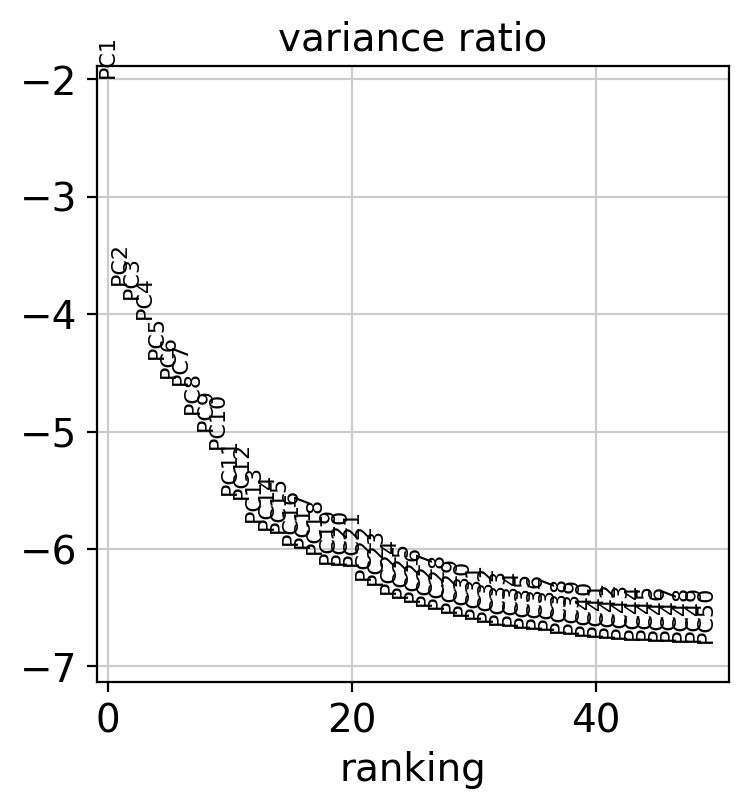

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)


ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.

In [16]:
import scanpy as sc
import matplotlib.pyplot as plt

# Basit QC
sc.pp.filter_genes(adata_sub, min_cells=3)

adata_sub.var["mt"] = adata_sub.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_sub, qc_vars=["mt"], percent_top=None, inplace=True)

# (İstersen QC plot bakabilirsin)
# sc.pl.violin(adata_sub, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#              jitter=0.4, multi_panel=True)

# Normalize + log1p
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)

# HVG
sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, subset=True)

# Scale + PCA
sc.pp.scale(adata_sub, max_value=10)
sc.tl.pca(adata_sub, n_comps=50, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_sub, log=True, n_pcs=50)
plt.show()

# Neighbors + UMAP + Leiden
sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.4, key_added="leiden_0_4")

# UMAP görselleri
sc.pl.umap(adata_sub, color=["leiden_0_4", "condition"], wspace=0.4)
if "infected" in adata_sub.obs.columns:
    sc.pl.umap(adata_sub, color=["infected", "viral_counts"], cmap="viridis", wspace=0.4)


In [17]:
!pip install leidenalg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.1 MB/s eta 0:00:00


In [18]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import glob
import re

from importlib.metadata import version
print("Scanpy version:", version("scanpy"))

# Genel Scanpy ayarları
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=False)


Scanpy version: 1.11.5


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)
running Leiden clustering


/tmp/ipython-input-2794538270.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_sub, resolution=0.4, key_added="leiden_0_4")


    finished: found 13 clusters and added
    'leiden_0_4', the cluster labels (adata.obs, categorical) (0:00:15)


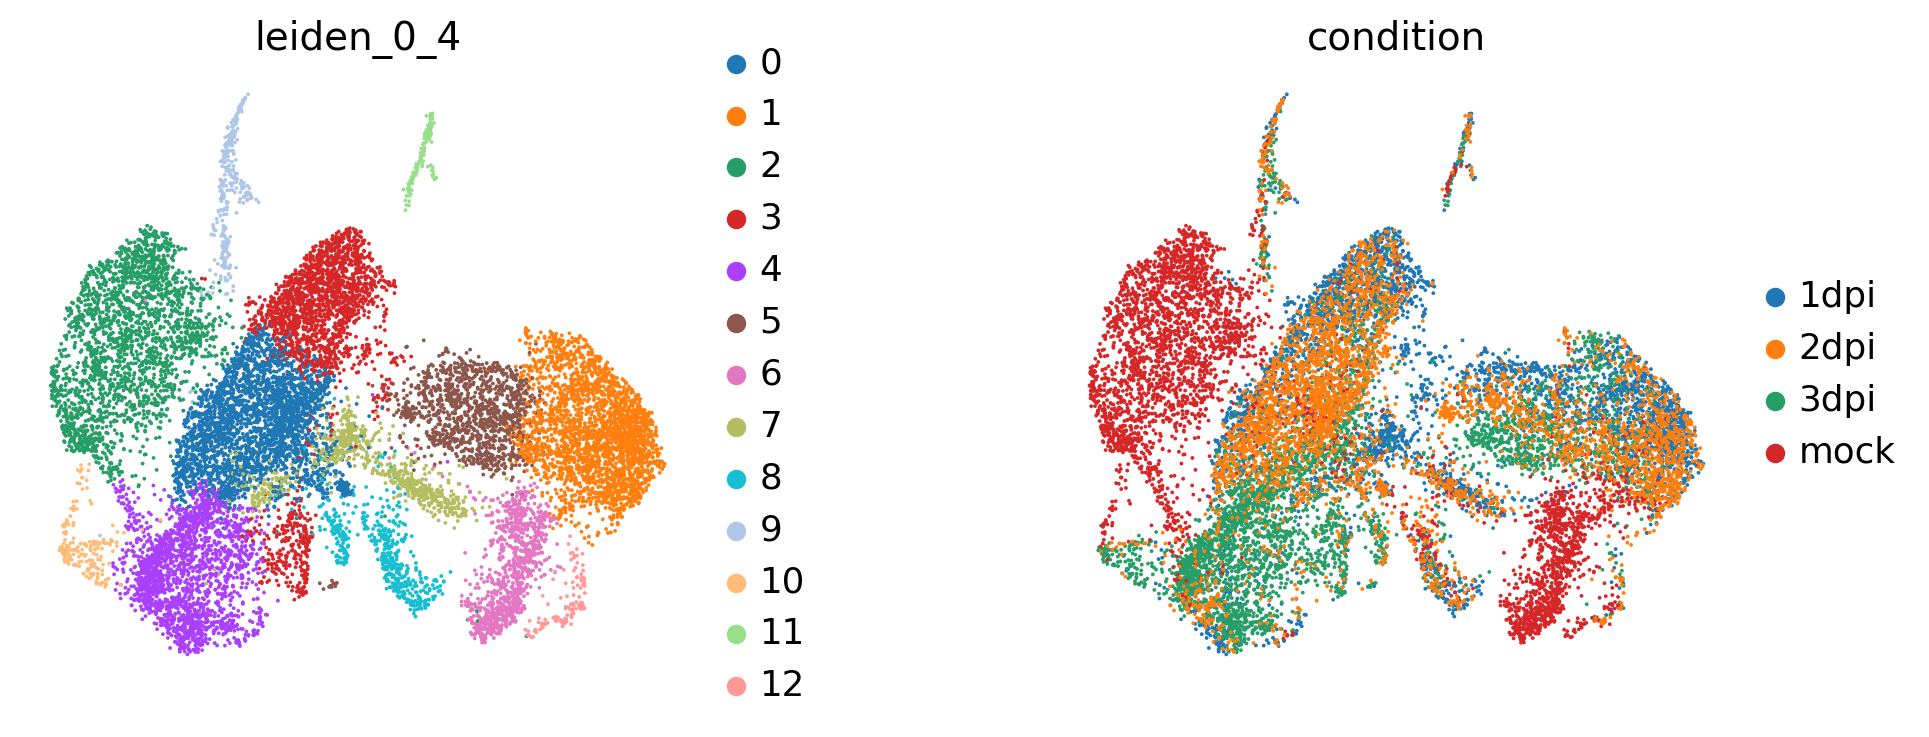

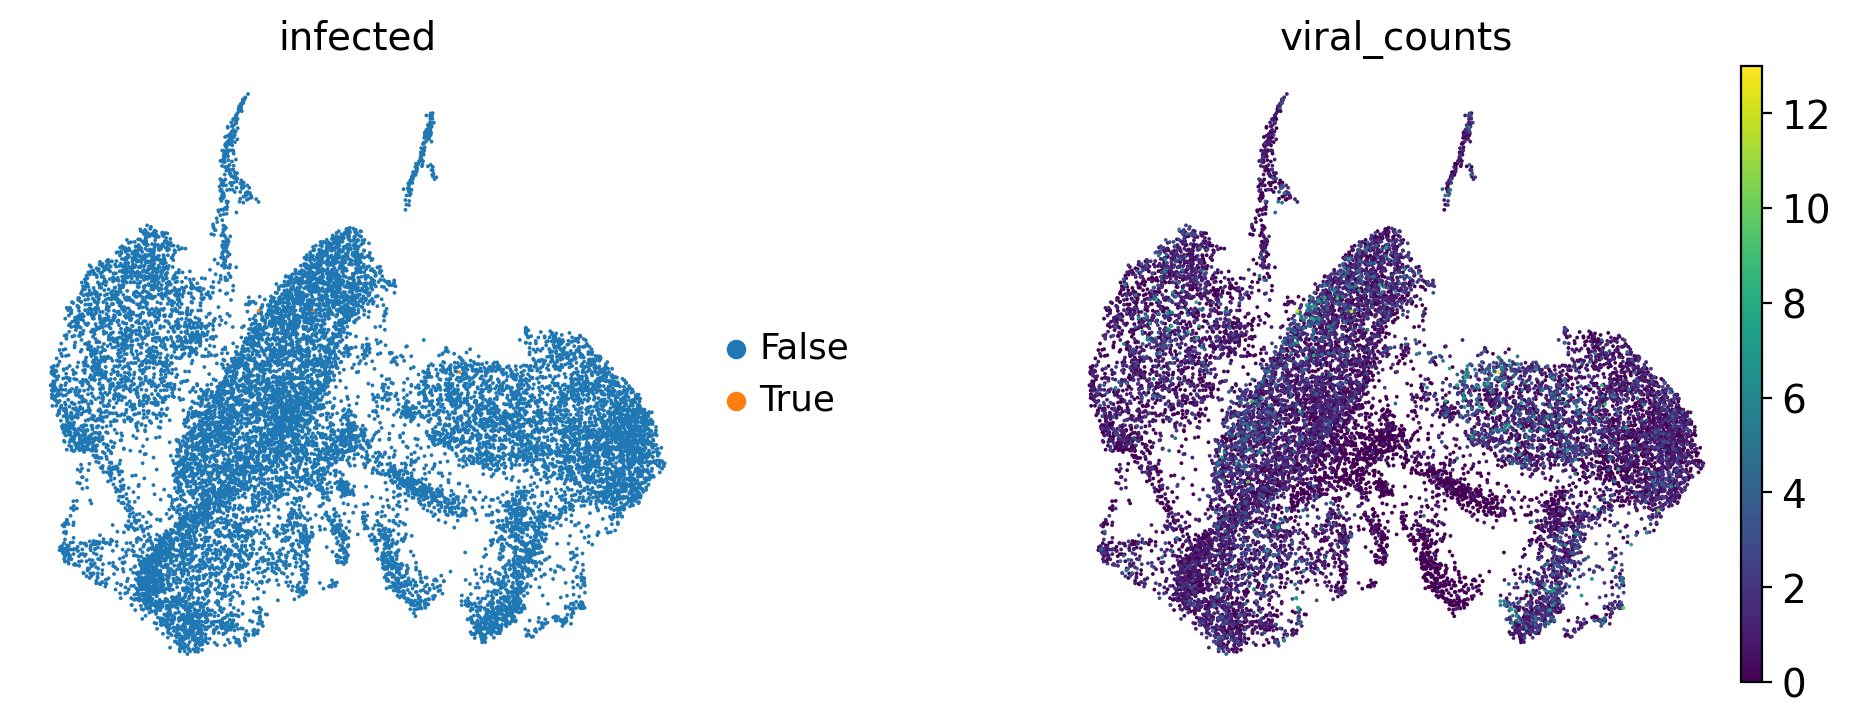

In [19]:
# Neighbors + UMAP + Leiden
sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.4, key_added="leiden_0_4")

# UMAP görselleri
sc.pl.umap(adata_sub, color=["leiden_0_4", "condition"], wspace=0.4)
if "infected" in adata_sub.obs.columns:
    sc.pl.umap(adata_sub, color=["infected", "viral_counts"], cmap="viridis", wspace=0.4)


In [21]:
marker_genes = {
    "Ciliated": ["FOXJ1", "PIFO", "TPPP3", "DNAH5"],
    "Basal": ["KRT5", "KRT14", "TP63"],
    "Club": ["SCGB1A1", "SCGB3A1"],
    "BC/club": ["KRT5", "SCGB1A1"],  # intermediate
    "Goblet": ["MUC5AC", "MUC5B"],
    "Ionocyte": ["FOXI1", "CFTR"],
    "Tuft": ["POU2F3", "TRPM5"],
    "Neuroendocrine": ["CHGA", "CHGB", "SYP"],
}

sc.pl.dotplot(
    adata_sub,
    marker_genes,
    groupby="leiden_0_4",
    standard_scale="var",
    dendrogram=True,
)
plt.show()


KeyError: "Could not find keys [np.str_('POU2F3'), np.str_('SCGB1A1'), np.str_('SCGB3A1'), np.str_('SYP'), np.str_('TPPP3'), np.str_('TRPM5')] in columns of `adata.obs` or in adata.var_names."

In [22]:
# ⚠️ Bu hücreyi adata_sub'ı yeniden oluşturduktan SONRA çalıştır

import scanpy as sc
import matplotlib.pyplot as plt

# 1) Basit QC
sc.pp.filter_genes(adata_sub, min_cells=3)

adata_sub.var["mt"] = adata_sub.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_sub, qc_vars=["mt"], percent_top=None, inplace=True)

# 2) Normalize + log1p
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)

# 🔴 ÖNEMLİ: ham (log-normalized) veriyi raw'a kaydet
adata_sub.raw = adata_sub

# 3) HVG: ARTIK subset=False → genleri silmiyoruz
sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, subset=False)

# 4) Scale + PCA
sc.pp.scale(adata_sub, max_value=10)
sc.tl.pca(adata_sub, n_comps=50, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_sub, log=True, n_pcs=50)
plt.show()

# 5) Neighbors + UMAP + Leiden
sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.4, key_added="leiden_0_4")

sc.pl.umap(adata_sub, color=["leiden_0_4", "condition"], wspace=0.4)
if "infected" in adata_sub.obs.columns:
    sc.pl.umap(adata_sub, color=["infected", "viral_counts"], cmap="viridis", wspace=0.4)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


extracting highly variable genes


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:391: RuntimeWarning: invalid value encountered in log1p
  np.log1p(x, out=x)


ValueError: Bin edges must be unique: Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [23]:
import numpy as np

print("Conditions:", adata.obs["condition"].unique())
print(adata.obs["condition"].value_counts())

n_per_cond = 4000  # RAM'e göre istersen 3000 de yapabilirsin

cells_sub = []
for cond_val in adata.obs["condition"].unique():
    mask = adata.obs["condition"] == cond_val
    idx = adata.obs_names[mask]
    if len(idx) > n_per_cond:
        sampled = adata.obs.loc[mask].sample(n=n_per_cond, random_state=0).index
    else:
        sampled = idx
    cells_sub.extend(sampled)

print("Total cells in subset:", len(cells_sub))
adata_sub = adata[cells_sub].copy()
print(adata_sub)


Conditions: ['1dpi' '3dpi' 'mock' '2dpi']
condition
3dpi    28530
mock    22609
2dpi    14695
1dpi    11834
Name: count, dtype: int64
Total cells in subset: 16000
AnnData object with n_obs × n_vars = 16000 × 33539
    obs: 'GSM', 'condition', 'sample'


In [24]:
# Viral genleri isimden tahmin et
viral_gene_mask = (
    adata_sub.var_names.str.upper().str.contains("SARS") |
    adata_sub.var_names.str.upper().str.contains("COV2") |
    adata_sub.var_names.str.upper().str.contains("COVID")
)
viral_genes = adata_sub.var_names[viral_gene_mask]

print("Number of viral genes detected:", len(viral_genes))
print("Example viral genes:", viral_genes[:20])

if len(viral_genes) > 0:
    viral_counts = np.array(adata_sub[:, viral_genes].X.sum(axis=1)).ravel()
    adata_sub.obs["viral_counts"] = viral_counts
    adata_sub.obs["infected"] = adata_sub.obs["viral_counts"] > 10
else:
    print("WARNING: No viral genes found with simple pattern search.")


Number of viral genes detected: 2
Example viral genes: Index(['SARS', 'SARS2'], dtype='object')


In [25]:
marker_genes = {
    "Ciliated": ["FOXJ1", "PIFO", "TPPP3", "DNAH5"],
    "Basal": ["KRT5", "KRT14", "TP63"],
    "Club": ["SCGB1A1", "SCGB3A1"],
    "BC/club": ["KRT5", "SCGB1A1"],  # intermediate
    "Goblet": ["MUC5AC", "MUC5B"],
    "Ionocyte": ["FOXI1", "CFTR"],
    "Tuft": ["POU2F3", "TRPM5"],
    "Neuroendocrine": ["CHGA", "CHGB", "SYP"],
}

# Bu datasette gerçekten var olan marker'ları filtrele
present_marker_genes = {}
for celltype, genes in marker_genes.items():
    present = [g for g in genes if g in adata_sub.var_names]
    if present:
        present_marker_genes[celltype] = present

print("Bulunan marker genler:")
for ct, genes in present_marker_genes.items():
    print(f"{ct}: {genes}")

# Dotplot'ta raw (log-normalized) veriyi kullan
sc.pl.dotplot(
    adata_sub,
    present_marker_genes,
    groupby="leiden_0_4",
    standard_scale="var",
    dendrogram=True,
    use_raw=True,
)
plt.show()


Bulunan marker genler:
Ciliated: ['FOXJ1', 'PIFO', 'TPPP3', 'DNAH5']
Basal: ['KRT5', 'KRT14', 'TP63']
Club: ['SCGB1A1', 'SCGB3A1']
BC/club: ['KRT5', 'SCGB1A1']
Goblet: ['MUC5AC', 'MUC5B']
Ionocyte: ['FOXI1', 'CFTR']
Tuft: ['POU2F3', 'TRPM5']
Neuroendocrine: ['CHGA', 'CHGB', 'SYP']


ValueError: groupby has to be a valid observation. Given leiden_0_4, is not in observations: ['GSM', 'condition', 'sample', 'viral_counts', 'infected'] 

computing neighbors
computing PCA
    with n_comps=40


/usr/local/lib/python3.12/dist-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 33539 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


    finished (0:00:19)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0_4', the cluster labels (adata.obs, categorical) (0:00:14)
Index(['GSM', 'condition', 'sample', 'viral_counts', 'infected', 'leiden_0_4'], dtype='object')


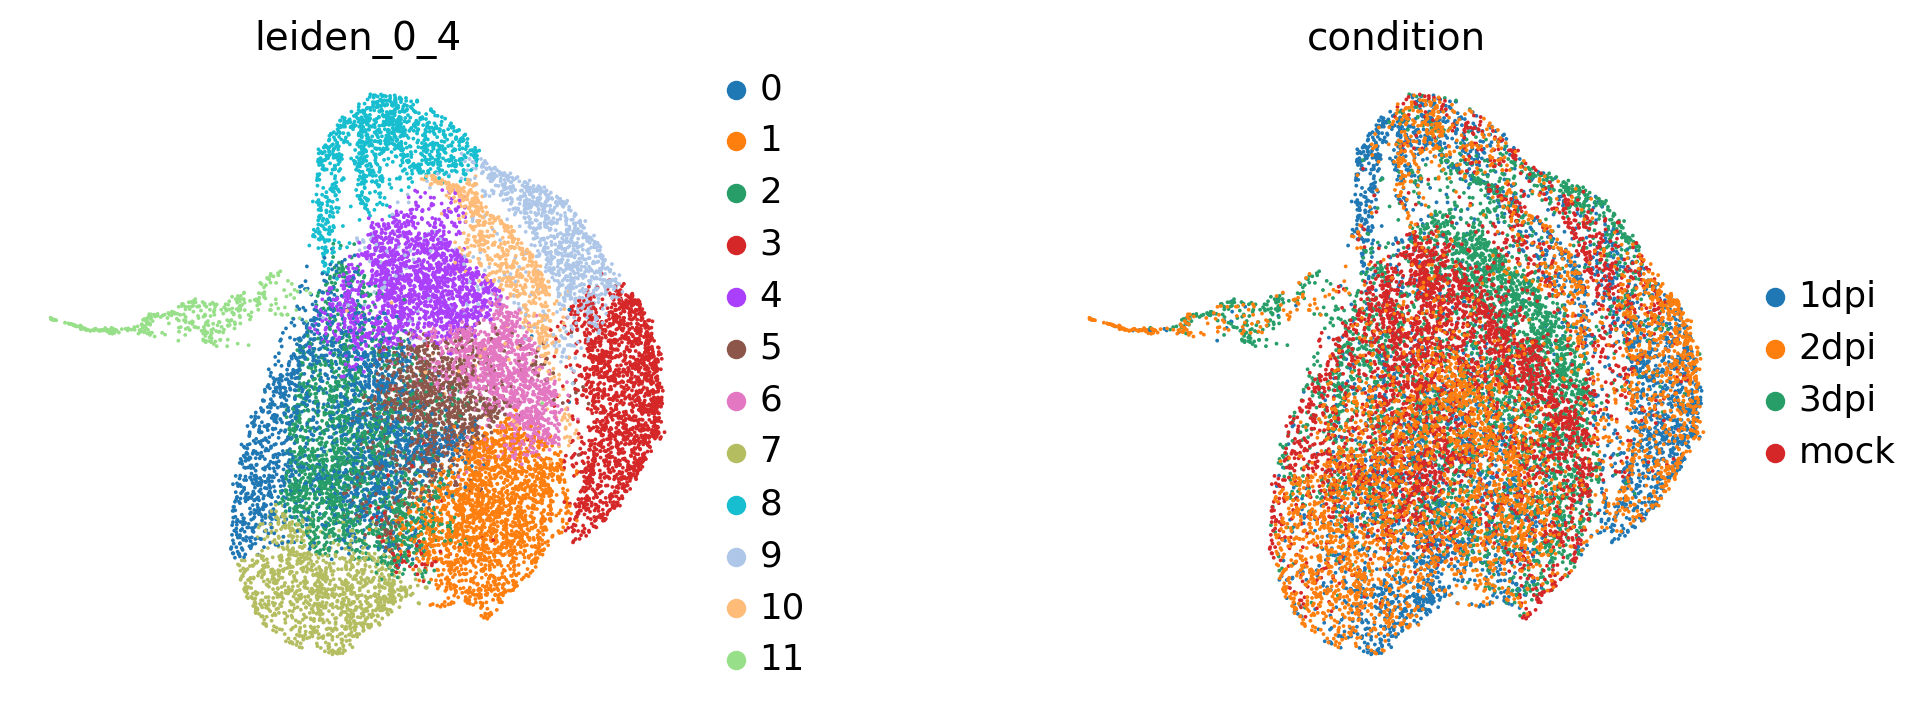

In [26]:
# Komşuluk grafiği + UMAP + Leiden'i yeniden hesapla
sc.pp.neighbors(adata_sub, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.4, key_added="leiden_0_4")

print(adata_sub.obs.columns)  # burada 'leiden_0_4' görünüyor olmalı

# Kontrol için UMAP
sc.pl.umap(adata_sub, color=["leiden_0_4", "condition"], wspace=0.4)


    using 'X_pca' with n_pcs = 40
Storing dendrogram info using `.uns['dendrogram_leiden_0_4']`
categories: 0, 1, 2, etc.
var_group_labels: Ciliated, Basal, Club, etc.


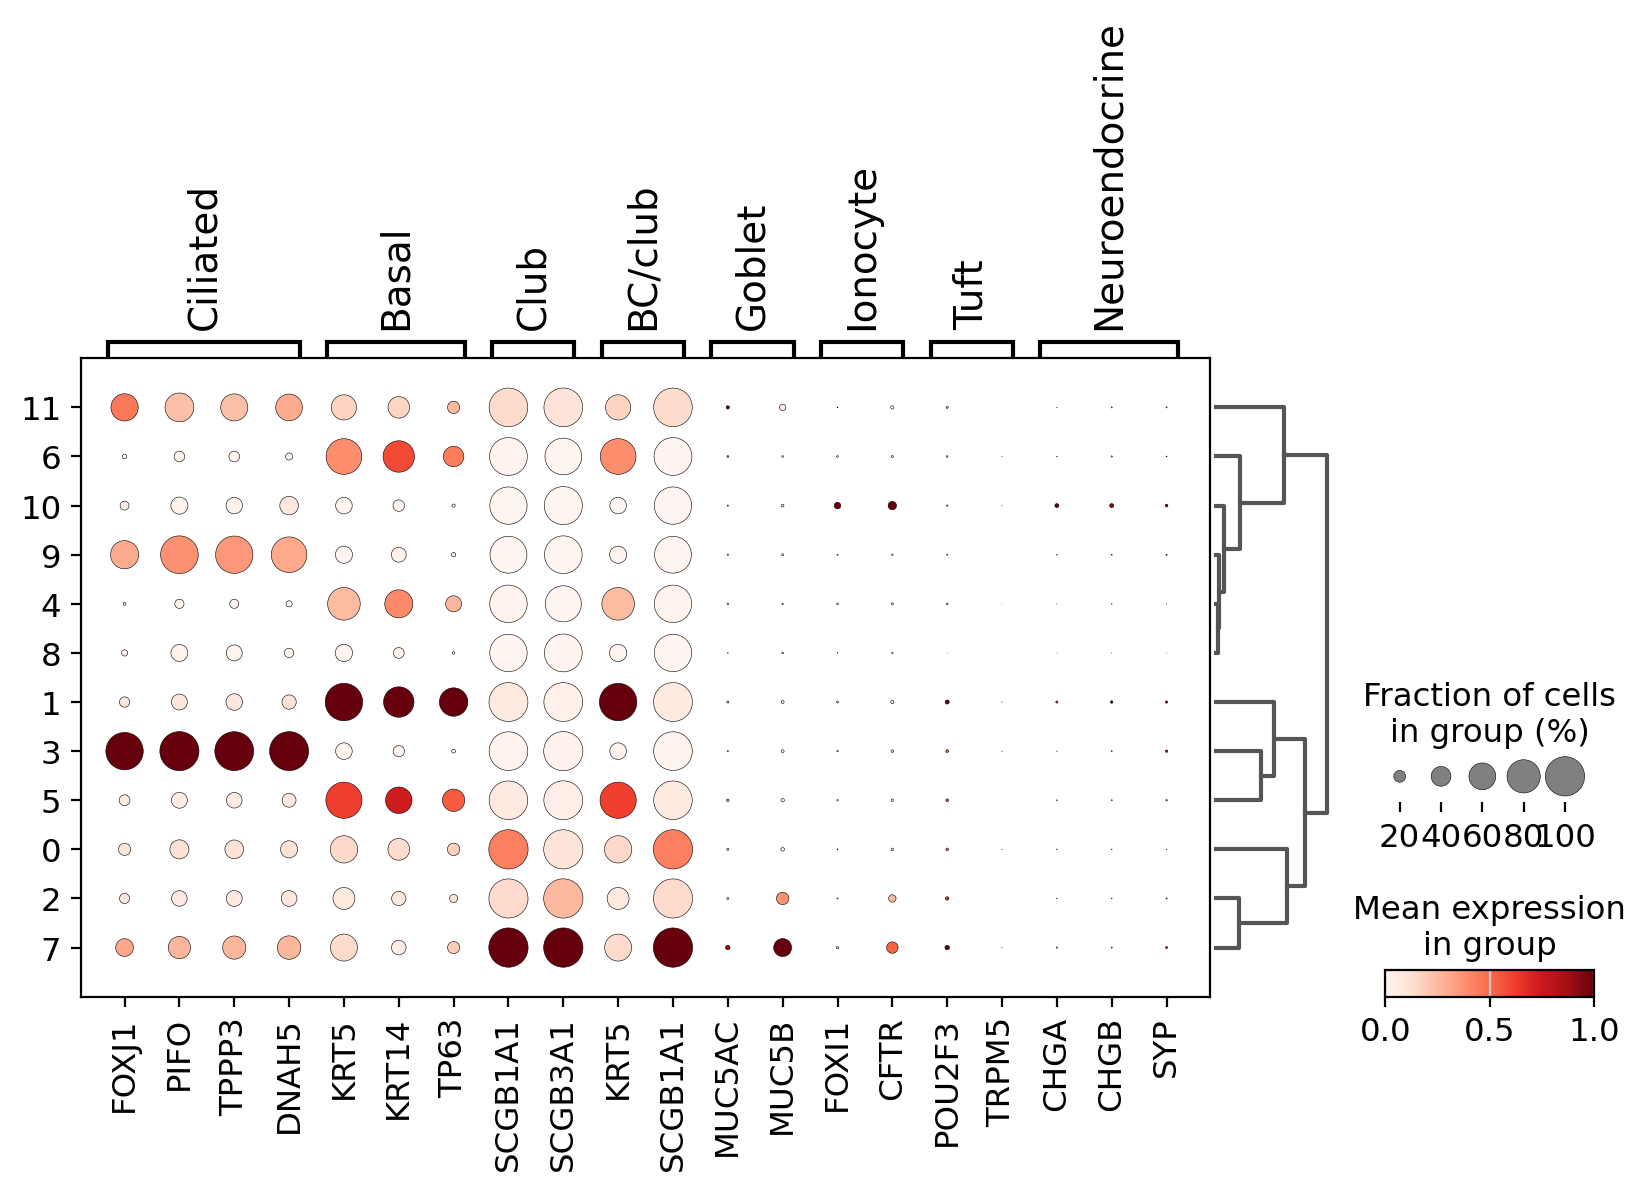

In [28]:
sc.pl.dotplot(
    adata_sub,
    present_marker_genes,
    groupby="leiden_0_4",
    standard_scale="var",
    dendrogram=True,
)
plt.show()


cell_type
BC/club     4779
Club        4659
Ciliated    3078
Basal       2366
Goblet      1118
Name: count, dtype: int64


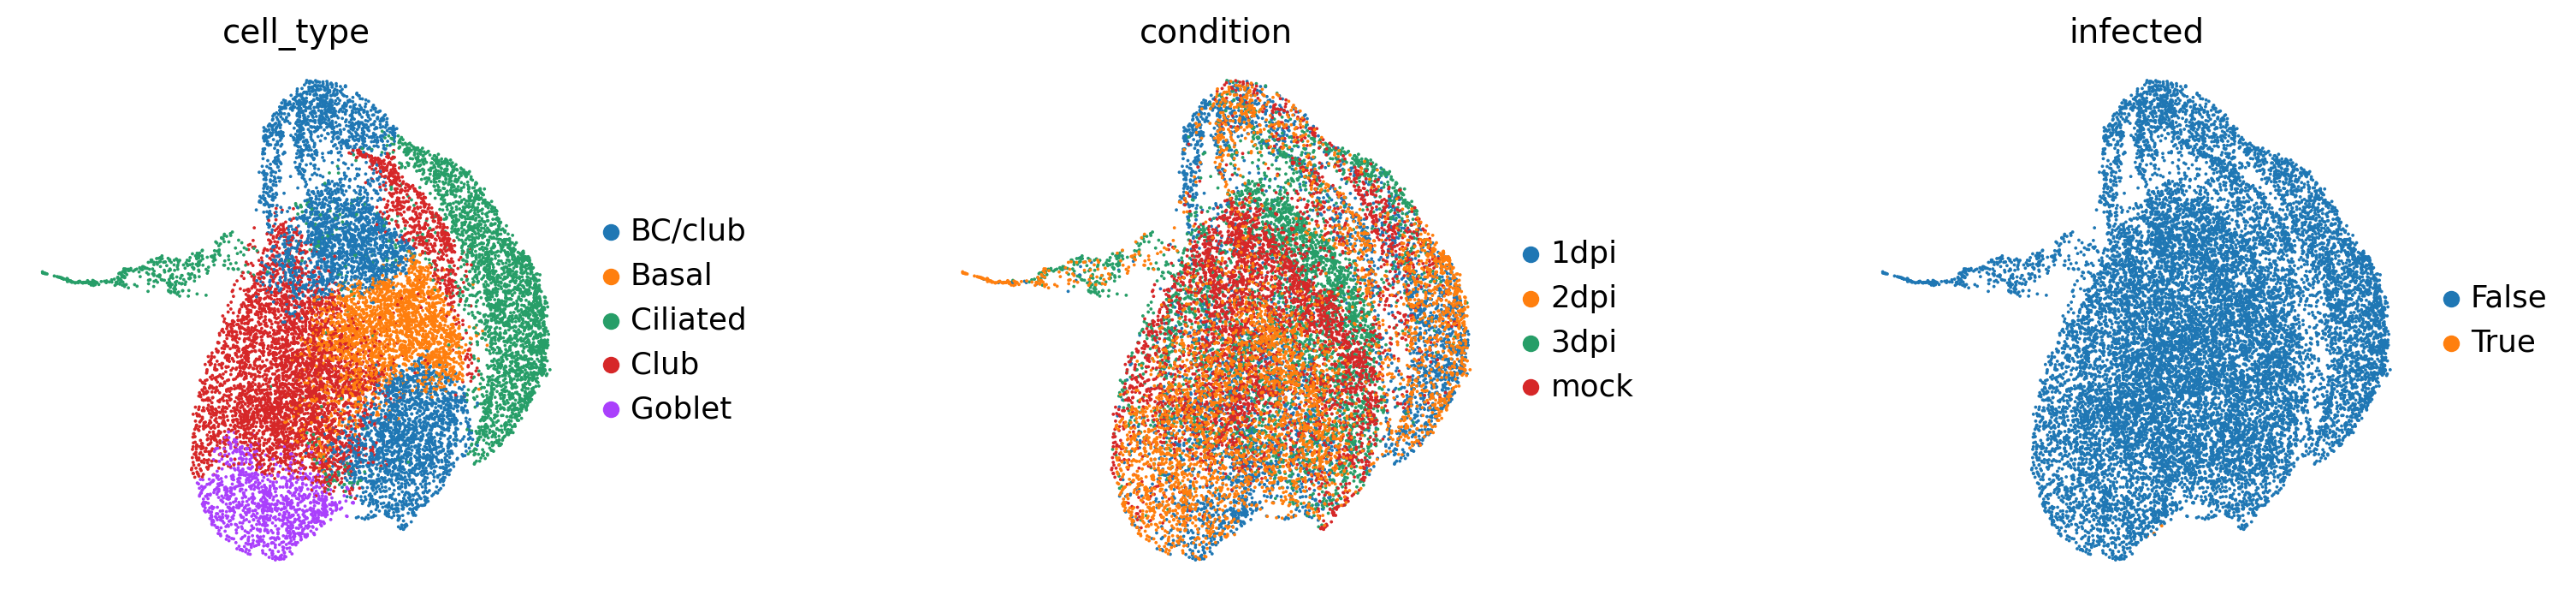

In [29]:
# Dotplot'tan okuduğumuz cluster → hücre tipi mapping
cluster_to_celltype = {
    "0":  "Club",
    "1":  "BC/club",      # karışık: biraz basal + club
    "2":  "Club",
    "3":  "Ciliated",
    "4":  "BC/club",
    "5":  "Basal",
    "6":  "Basal",
    "7":  "Goblet",
    "8":  "BC/club",
    "9":  "Ciliated",
    "10": "Club",
    "11": "Ciliated",
}

adata_sub.obs["cell_type"] = adata_sub.obs["leiden_0_4"].map(cluster_to_celltype)
print(adata_sub.obs["cell_type"].value_counts())

# UMAP üzerinde hücre tipleri
sc.pl.umap(adata_sub, color=["cell_type", "condition", "infected"], wspace=0.5)


In [30]:
# Sadece 3dpi hücreleri
adata_3dpi = adata[adata.obs["condition"] == "3dpi"].copy()
print(adata_3dpi)


AnnData object with n_obs × n_vars = 28530 × 33539
    obs: 'GSM', 'condition', 'sample'


In [3]:
!pip install --quiet scanpy anndata matplotlib leidenalg

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil, re

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, frameon=False)


In [4]:
# RAW klasöründeki dosyaları al
files = os.listdir("GSE166766_RAW")
files


['GSM5082290_1dpi_features.tsv.gz',
 'GSM5082292_3dpi_matrix.mtx.gz',
 'GSM5082289_mock_features.tsv.gz',
 'GSM5082292_3dpi_features.tsv.gz',
 'GSM5082291_2dpi_barcodes.tsv.gz',
 'GSM5082292_3dpi_barcodes.tsv.gz',
 'GSM5082289_mock_matrix.mtx.gz',
 'GSM5082291_2dpi_matrix.mtx.gz',
 'GSM5082289_mock_barcodes.tsv.gz',
 'GSM5082290_1dpi_barcodes.tsv.gz',
 'GSM5082291_2dpi_features.tsv.gz',
 'GSM5082290_1dpi_matrix.mtx.gz']

In [5]:
# Dosyaları GSM bazında grupla
data_groups = {}

for f in files:
    m = re.match(r"(GSM\d+)_([a-zA-Z0-9]+)_(.+)", f)
    if m:
        gsm = m.group(1)
        suffix = m.group(3)  # matrix.mtx.gz, barcodes.tsv.gz, features.tsv.gz
        if gsm not in data_groups:
            data_groups[gsm] = {}
        data_groups[gsm][suffix] = os.path.join("GSE166766_RAW", f)

data_groups


{'GSM5082290': {'features.tsv.gz': 'GSE166766_RAW/GSM5082290_1dpi_features.tsv.gz',
  'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082290_1dpi_barcodes.tsv.gz',
  'matrix.mtx.gz': 'GSE166766_RAW/GSM5082290_1dpi_matrix.mtx.gz'},
 'GSM5082292': {'matrix.mtx.gz': 'GSE166766_RAW/GSM5082292_3dpi_matrix.mtx.gz',
  'features.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_features.tsv.gz',
  'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_barcodes.tsv.gz'},
 'GSM5082289': {'features.tsv.gz': 'GSE166766_RAW/GSM5082289_mock_features.tsv.gz',
  'matrix.mtx.gz': 'GSE166766_RAW/GSM5082289_mock_matrix.mtx.gz',
  'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082289_mock_barcodes.tsv.gz'},
 'GSM5082291': {'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082291_2dpi_barcodes.tsv.gz',
  'matrix.mtx.gz': 'GSE166766_RAW/GSM5082291_2dpi_matrix.mtx.gz',
  'features.tsv.gz': 'GSE166766_RAW/GSM5082291_2dpi_features.tsv.gz'}}

In [6]:
gsm = "GSM5082292"   # 3dpi
files_dict = data_groups[gsm]
files_dict


{'matrix.mtx.gz': 'GSE166766_RAW/GSM5082292_3dpi_matrix.mtx.gz',
 'features.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_features.tsv.gz',
 'barcodes.tsv.gz': 'GSE166766_RAW/GSM5082292_3dpi_barcodes.tsv.gz'}

In [7]:
# Geçici klasör oluştur
tmp_dir = f"tmp_{gsm}"
os.makedirs(tmp_dir, exist_ok=True)

for fname in ["matrix.mtx.gz", "barcodes.tsv.gz", "features.tsv.gz"]:
    fpath = os.path.join(tmp_dir, fname)
    if os.path.exists(fpath):
        os.remove(fpath)

shutil.copy(files_dict["matrix.mtx.gz"], os.path.join(tmp_dir, "matrix.mtx.gz"))
shutil.copy(files_dict["barcodes.tsv.gz"], os.path.join(tmp_dir, "barcodes.tsv.gz"))
shutil.copy(files_dict["features.tsv.gz"], os.path.join(tmp_dir, "features.tsv.gz"))

# 3dpi datasını oku
adata_3dpi = sc.read_10x_mtx(
    tmp_dir,
    var_names="gene_symbols",
    cache=False,
)
adata_3dpi.var_names_make_unique()
adata_3dpi.obs["condition"] = "3dpi"

print(adata_3dpi)


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
AnnData object with n_obs × n_vars = 28530 × 33539
    obs: 'condition'
    var: 'gene_ids', 'feature_types'


In [8]:
# Viral genleri bul
viral_gene_mask_3 = (
    adata_3dpi.var_names.str.upper().str.contains("SARS") |
    adata_3dpi.var_names.str.upper().str.contains("COV2") |
    adata_3dpi.var_names.str.upper().str.contains("COVID")
)
viral_genes_3 = adata_3dpi.var_names[viral_gene_mask_3]
print("3 dpi viral genes:", len(viral_genes_3))
print("Example viral genes:", viral_genes_3[:10])

if len(viral_genes_3) > 0:
    viral_counts_3 = np.array(adata_3dpi[:, viral_genes_3].X.sum(axis=1)).ravel()
    adata_3dpi.obs["viral_counts"] = viral_counts_3
    adata_3dpi.obs["infected"] = adata_3dpi.obs["viral_counts"] > 10
else:
    print("WARNING: no viral genes detected by name pattern.")


3 dpi viral genes: 2
Example viral genes: Index(['SARS', 'SARS2'], dtype='object')


In [9]:
# QC
sc.pp.filter_genes(adata_3dpi, min_cells=3)
adata_3dpi.var["mt"] = adata_3dpi.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_3dpi, qc_vars=["mt"], percent_top=None, inplace=True)

# Normalize + log
sc.pp.normalize_total(adata_3dpi, target_sum=1e4)
sc.pp.log1p(adata_3dpi)

# HVG – cell_ranger (SEURAT DEĞİL)
sc.pp.highly_variable_genes(
    adata_3dpi,
    n_top_genes=2000,
    subset=False,
    flavor="cell_ranger",
)

print("Number of HVGs:", adata_3dpi.var["highly_variable"].sum())


filtered out 11288 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of HVGs: 2000


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


computing PCA
    with n_comps=30
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:25)
running Leiden clustering


/tmp/ipython-input-3367880908.py:13: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_3dpi, resolution=0.4, key_added="leiden_0_4")


    finished: found 13 clusters and added
    'leiden_0_4', the cluster labels (adata.obs, categorical) (0:00:32)


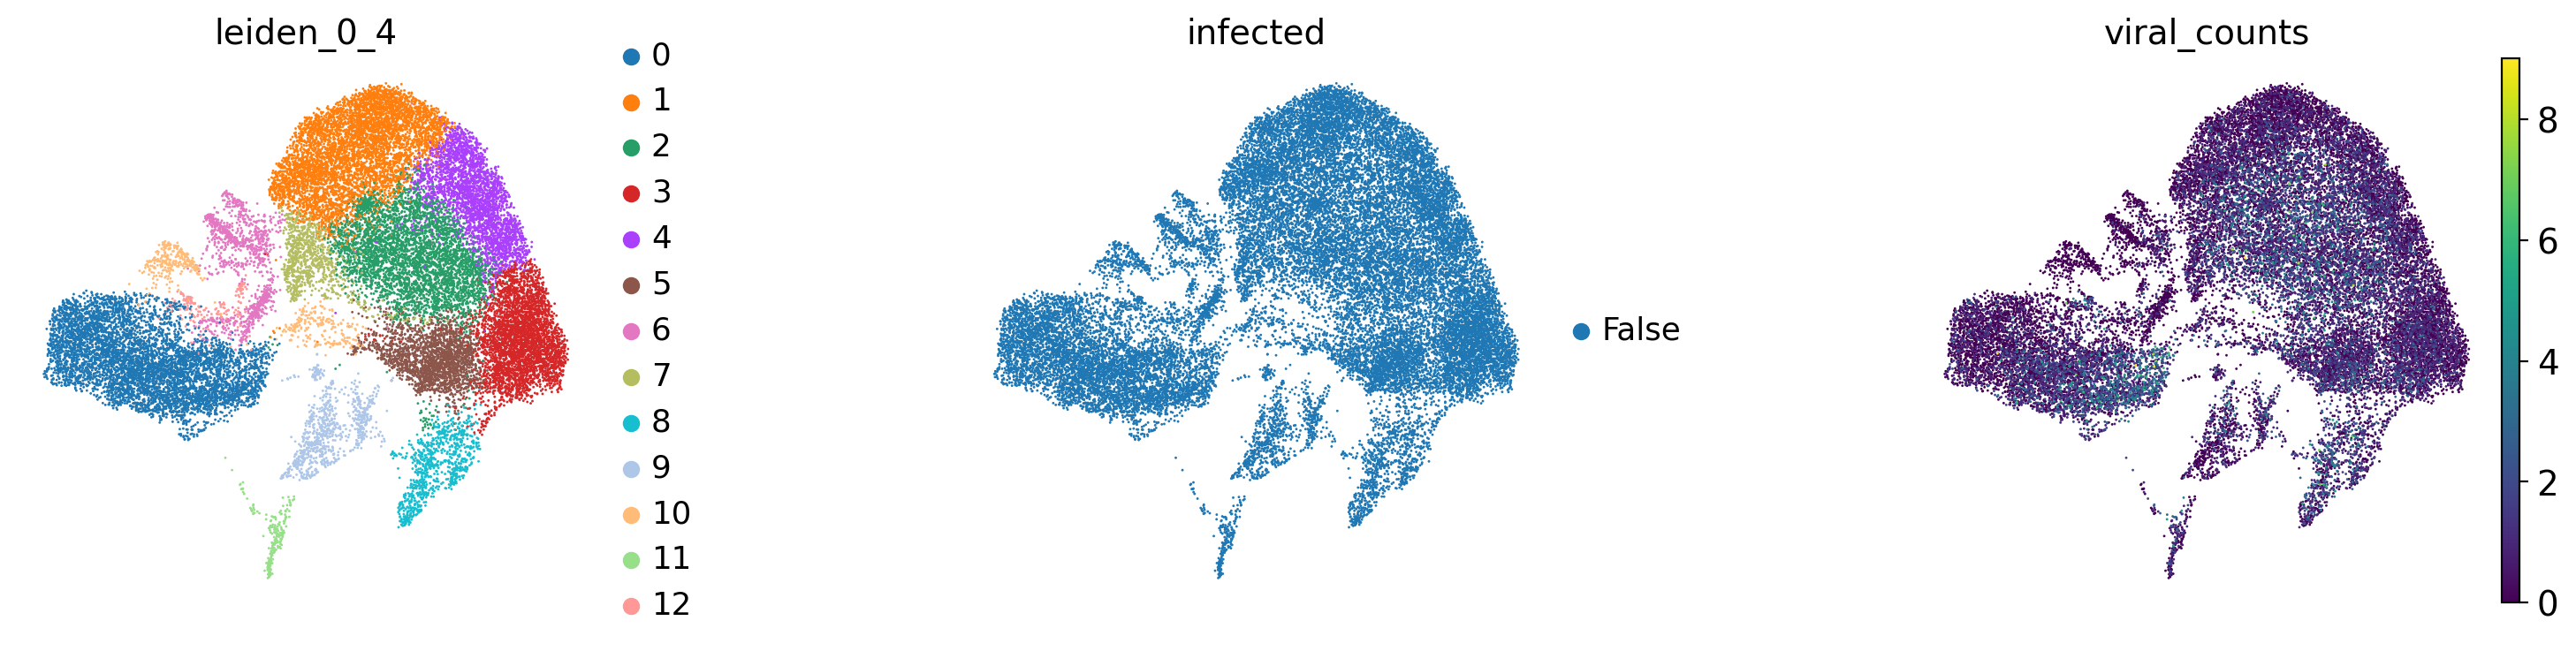

In [10]:
# Sadece HVG'lerden PCA / neighbors / UMAP için küçük bir kopya
adata_3dpi_hvg = adata_3dpi[:, adata_3dpi.var["highly_variable"]].copy()

sc.pp.scale(adata_3dpi_hvg, max_value=10)
sc.tl.pca(adata_3dpi_hvg, n_comps=30, svd_solver="arpack")

# PCA koordinatlarını ana objeye kopyala
adata_3dpi.obsm["X_pca"] = adata_3dpi_hvg.obsm["X_pca"]

# Komşuluk + UMAP + Leiden
sc.pp.neighbors(adata_3dpi, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_3dpi)
sc.tl.leiden(adata_3dpi, resolution=0.4, key_added="leiden_0_4")

sc.pl.umap(adata_3dpi, color=["leiden_0_4", "infected", "viral_counts"], cmap="viridis", wspace=0.5)


3 dpi'de bulunan markerlar:
Ciliated : ['FOXJ1', 'PIFO', 'TPPP3', 'DNAH5']
Basal : ['KRT5', 'KRT14', 'TP63']
Club : ['SCGB1A1', 'SCGB3A1']
BC/club : ['KRT5', 'SCGB1A1']
Goblet : ['MUC5AC', 'MUC5B']
Ionocyte : ['FOXI1', 'CFTR']
Tuft : ['POU2F3', 'TRPM5']
Neuroendocrine : ['CHGA', 'CHGB', 'SYP']
    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_leiden_0_4']`
categories: 0, 1, 2, etc.
var_group_labels: Ciliated, Basal, Club, etc.


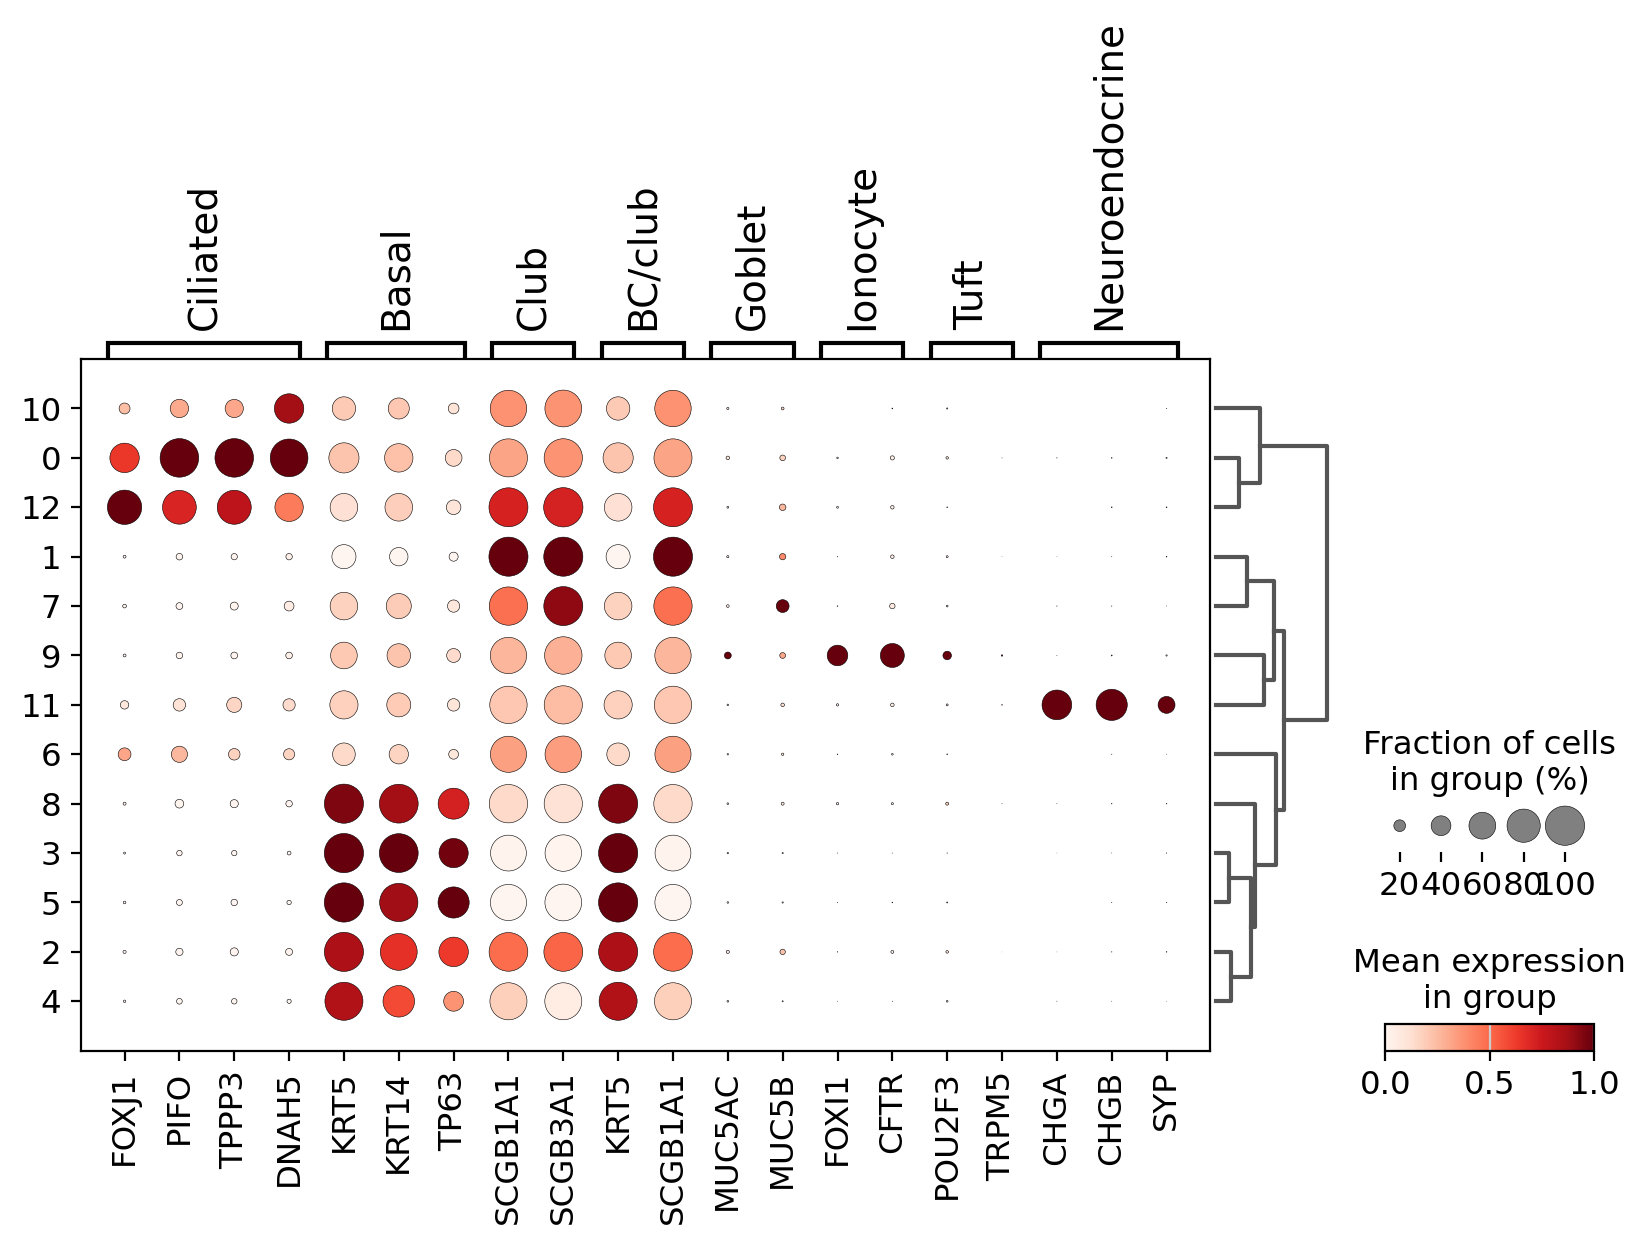

In [11]:
marker_genes = {
    "Ciliated": ["FOXJ1", "PIFO", "TPPP3", "DNAH5"],
    "Basal": ["KRT5", "KRT14", "TP63"],
    "Club": ["SCGB1A1", "SCGB3A1"],
    "BC/club": ["KRT5", "SCGB1A1"],
    "Goblet": ["MUC5AC", "MUC5B"],
    "Ionocyte": ["FOXI1", "CFTR"],
    "Tuft": ["POU2F3", "TRPM5"],
    "Neuroendocrine": ["CHGA", "CHGB", "SYP"],
}

present_marker_genes_3 = {}
for ct, genes in marker_genes.items():
    present = [g for g in genes if g in adata_3dpi.var_names]
    if present:
        present_marker_genes_3[ct] = present

print("3 dpi'de bulunan markerlar:")
for ct, genes in present_marker_genes_3.items():
    print(ct, ":", genes)

sc.pl.dotplot(
    adata_3dpi,
    present_marker_genes_3,
    groupby="leiden_0_4",
    standard_scale="var",
    dendrogram=True,
)
plt.show()


Cluster → cell type mapping (3 dpi):
{'0': 'Club', '1': 'Club', '2': 'Club', '3': 'Basal', '4': 'BC/club', '5': 'Basal', '6': 'Club', '7': 'Club', '8': 'BC/club', '9': 'Club', '10': 'Club', '11': 'Club', '12': 'Club'}
cell_type
Club       18905
Basal       5826
BC/club     3799
Name: count, dtype: int64


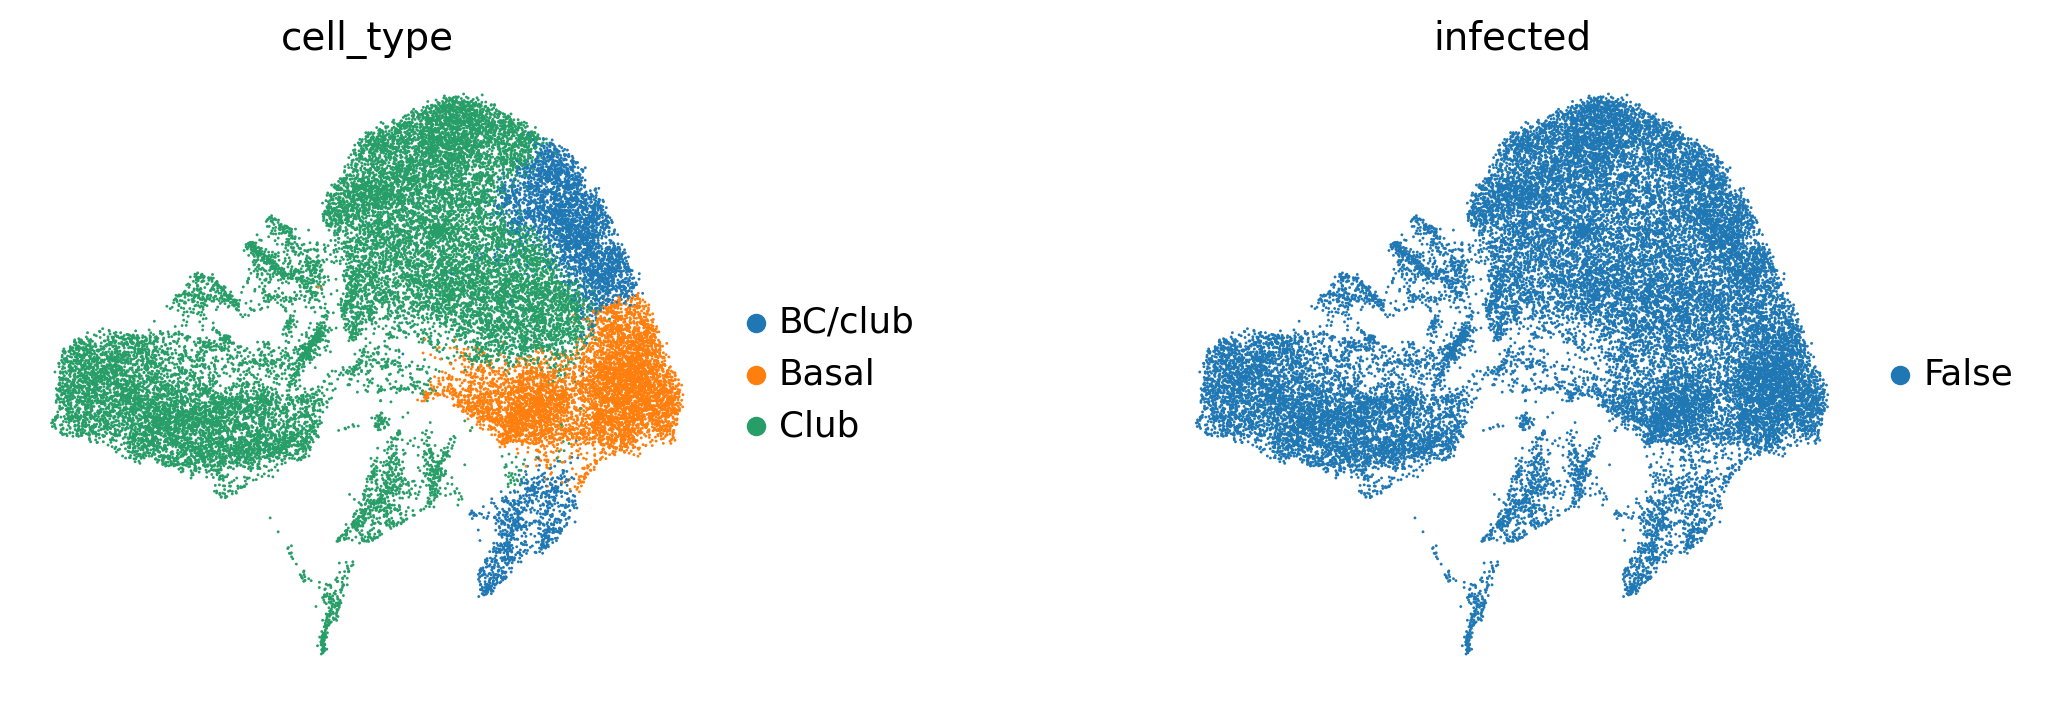

In [12]:
import numpy as np

# present_marker_genes_3 zaten tanımlı (Ciliated, Basal, Club, ...)

cluster_to_celltype_3dpi = {}

for cl in adata_3dpi.obs["leiden_0_4"].cat.categories:
    mask = adata_3dpi.obs["leiden_0_4"] == cl
    ad_cl = adata_3dpi[mask].copy()

    scores = {}
    for ct, genes in present_marker_genes_3.items():
        genes_in = [g for g in genes if g in ad_cl.var_names]
        if len(genes_in) == 0:
            continue
        # Sparse de olsa ortalamayı al
        X_sub = ad_cl[:, genes_in].X
        mean_expr = np.array(X_sub.mean())  # tek sayı döner
        scores[ct] = float(mean_expr)

    if len(scores) == 0:
        best_ct = "Unknown"
    else:
        best_ct = max(scores, key=scores.get)

    cluster_to_celltype_3dpi[cl] = best_ct

print("Cluster → cell type mapping (3 dpi):")
print(cluster_to_celltype_3dpi)

adata_3dpi.obs["cell_type"] = adata_3dpi.obs["leiden_0_4"].map(cluster_to_celltype_3dpi)
print(adata_3dpi.obs["cell_type"].value_counts())

# UMAP üzerinde cell type + infection
sc.pl.umap(adata_3dpi, color=["cell_type", "infected"], wspace=0.5)


computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


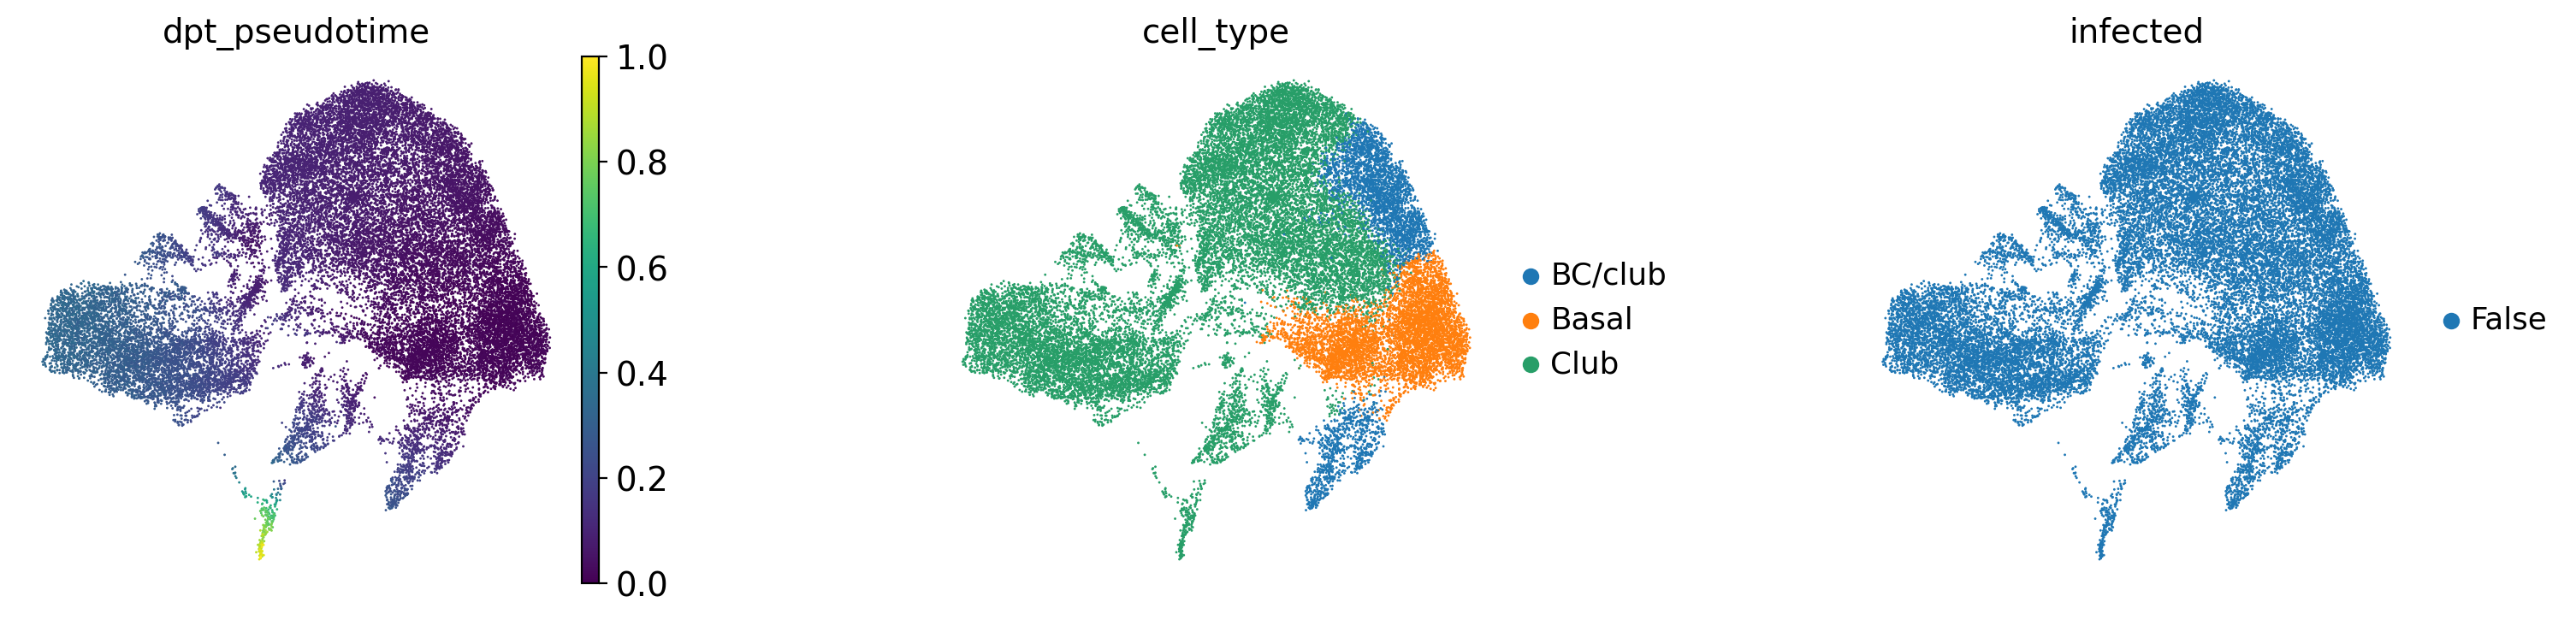

In [14]:
# Root olarak seçilen hücre indexini bul
root_index = np.where(adata_3dpi.obs_names == root_cell)[0][0]

# iroot parametresi buraya verilir
adata_3dpi.uns['iroot'] = root_index

# DPT (root_cells parametresi YOK!)
sc.tl.dpt(adata_3dpi, n_dcs=10)

# Plot
sc.pl.umap(
    adata_3dpi,
    color=["dpt_pseudotime", "cell_type", "infected"],
    color_map="viridis",
    wspace=0.5,
)
plt.show()


In [15]:
import numpy as np

def find_gene_name_exact_case_insensitive(gene, var_names):
    upper = var_names.str.upper()
    hits = var_names[upper == gene.upper()]
    return hits[0] if len(hits) > 0 else None

# ACE2 gen adını bul
ace2_name = find_gene_name_exact_case_insensitive("ACE2", adata_3dpi.var_names)
print("ACE2:", ace2_name)

if ace2_name is None:
    print("ACE2 bu matriste bulunamadı, gene isimlerini kontrol etmen lazım (örn. ENSG...).")
else:
    # Cluster bazında ortalama ACE2 ifadesi
    df_cluster = (
        adata_3dpi.to_df()[[ace2_name]]
        .join(adata_3dpi.obs["leiden_0_4"])
        .groupby("leiden_0_4")
        .mean()
        .sort_values(by=ace2_name, ascending=False)
    )
    print("\nACE2 ortalama ifadesi (cluster bazında):")
    print(df_cluster)

    # Cell type bazında ortalama ACE2 ifadesi
    if "cell_type" in adata_3dpi.obs.columns:
        df_ct = (
            adata_3dpi.to_df()[[ace2_name]]
            .join(adata_3dpi.obs["cell_type"])
            .groupby("cell_type")
            .mean()
            .sort_values(by=ace2_name, ascending=False)
        )
        print("\nACE2 ortalama ifadesi (cell type bazında):")
        print(df_ct)


ACE2: ACE2


/tmp/ipython-input-815032650.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("leiden_0_4")



ACE2 ortalama ifadesi (cluster bazında):
                ACE2
leiden_0_4          
7           0.166053
0           0.044257
1           0.040251
2           0.035479
11          0.029431
12          0.026159
9           0.022969
4           0.022947
5           0.021285
8           0.019875
10          0.017258
6           0.014687
3           0.013519

ACE2 ortalama ifadesi (cell type bazında):
               ACE2
cell_type          
Club       0.043242
BC/club    0.022267
Basal      0.016398


/tmp/ipython-input-815032650.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("cell_type")
